In [4]:
import cfbd
import numpy as np
import pandas as pd
import openpyxl

from api_key import API_KEY
from fastai.tabular import *
from fastai.tabular.all import *

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = API_KEY

api_config = cfbd.ApiClient(configuration)

teams_api = cfbd.TeamsApi(api_config)
ratings_api = cfbd.RatingsApi(api_config)
games_api = cfbd.GamesApi(api_config)
stats_api = cfbd.StatsApi(api_config)
betting_api = cfbd.BettingApi(api_config)

games = []
lines = []

for year in range(2015, 2022):
    response = games_api.get_games(year=year)
    games = [*games, *response]

    response = betting_api.get_lines(year=year)
    lines = [*lines, *response]

games = [g for g in games if g.home_conference is not None and g.away_conference is not None and g.home_points is not None and g.away_points is not None]

In [5]:
games = [
    dict(
        id = g.id,
        year = g.season,
        week = g.week,
        neutral_site = g.neutral_site,
        home_team = g.home_team,
        home_conference = g.home_conference,
        home_points = g.home_points,
        home_elo = g.home_pregame_elo,
        away_team = g.away_team,
        away_conference = g.away_conference,
        away_points = g.away_points,
        away_elo = g.away_pregame_elo
    ) for g in games]


In [6]:
for game in games:
    game_lines = [l for l in lines if l.id == game['id']]

    if len(game_lines) > 0:
        game_line = [l for l in game_lines[0].lines if l['provider'] == 'Bovada']

        if len(game_line) > 0 and game_line[0]['spread'] is not None:
            game['spread'] = float(game_line[0]['spread'])
        if len(game_line) > 0 and game_line[0]['overUnder'] is not None:
            game['overUnder'] = float(game_line[0]['overUnder'])

In [7]:
games = [g for g in games if 'spread' in g and g['spread'] is not None]
games = [g for g in games if 'overUnder' in g and g['overUnder'] is not None]

len(games)

1456

In [8]:
for game in games:
    game['margin'] = game['away_points'] - game['home_points']
    game['total'] = game['away_points'] + game['home_points']

In [9]:
df = pd.DataFrame.from_records(games).dropna()
df.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,spread,overUnder,margin,total
0,401121960,2019,10,False,Appalachian State,Sun Belt,21,1770,Georgia Southern,Sun Belt,24,1396,-14.0,41.5,3,45
1,401112080,2019,10,False,Baylor,Big 12,17,1665,West Virginia,Big 12,14,1530,-18.0,57.0,-3,31
2,401117894,2019,10,False,Connecticut,American Athletic,10,996,Navy,American Athletic,56,1599,26.5,55.0,46,66
3,401112495,2019,10,False,Syracuse,ACC,27,1458,Boston College,ACC,58,1489,-3.0,59.0,31,85
4,401114352,2019,10,False,UMass,FBS Independents,21,832,Liberty,FBS Independents,63,1264,24.0,72.0,42,84


In [10]:
test_df = df.query("year == 2021")
train_df = df.query("year != 2021")

In [11]:
excluded = ['id','year','week','home_team','away_team','margin', 'total', 'home_points', 'away_points']
cat_features = ['home_conference','away_conference','neutral_site']
cont_features = [c for c in df.columns.to_list() if c not in cat_features and c not in excluded]

cont_features

['home_elo', 'away_elo', 'spread', 'overUnder']

In [12]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
splits

((#580) [182,519,12,144,209,642,3,605,84,530...],
 (#145) [661,202,456,659,105,364,496,259,305,648...])

In [13]:
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                    y_names={"margin", "total"},
                    cat_names = cat_features,
                    cont_names = cont_features,
                   splits=splits)

In [14]:
dls = to.dataloaders(bs=64)
dls.show_batch()

,home_conference,away_conference,neutral_site,home_elo,away_elo,spread,overUnder,margin,total
0,Big 12,Big 12,False,1594.000002,1448.000000,-9.5,61.500000,-16.0,52.0
1,ACC,ACC,False,2194.000007,1369.999998,-48.0,64.000000,-26.0,68.0
2,American Athletic,American Athletic,False,1608.000002,1703.000001,-2.5,75.000000,-3.0,57.0
3,Sun Belt,Sun Belt,False,1627.000002,1526.000000,-12.5,73.999999,-50.0,56.0
4,Sun Belt,Conference USA,False,1205.999994,1222.000004,-6.0,56.500000,3.0,99.0
5,Mountain West,Mountain West,False,1616.000002,1346.000001,-7.5,45.500000,-12.0,46.0
6,Big 12,Big 12,False,1665.000001,1530.000001,-18.0,57.000000,-3.0,31.0
7,Conference USA,Conference USA,False,1417.999998,1619.999999,-6.5,54.500000,-21.0,41.0
8,Pac-12,Pac-12,False,1482.000001,1388.000000,-10.0,70.000000,-17.0,37.0
9,ACC,ACC,False,1644.000002,1659.000004,-2.0,67.500000,1.0,49.0


In [15]:
learn = tabular_learner(dls, metrics=mae, lr=10e-1)

SuggestedLRs(valley=0.019054606556892395)

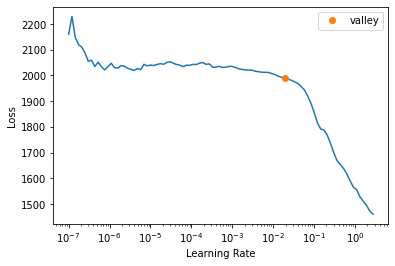

In [16]:
learn.lr_find()

In [17]:
learn = tabular_learner(dls, metrics=mae, lr=10e-2)
learn.fit(10)

epoch,train_loss,valid_loss,mae,time
0,1334.212402,346.128021,15.205886,00:02
1,830.261353,498.369720,17.823296,00:01
2,637.397217,298.062347,13.781591,00:01
3,521.908997,293.899200,13.674091,00:01
4,455.512543,268.573547,12.948856,00:01
5,405.585236,295.363525,13.497483,00:01
6,370.583405,278.095886,13.162575,00:01
7,345.050079,298.170563,13.730032,00:01
8,326.684998,286.501526,13.311981,00:01
9,311.137878,302.929138,13.683119,00:01


In [18]:
learn = tabular_learner(dls, metrics=mae, lr=10e-2)
learn.fit(5)

epoch,train_loss,valid_loss,mae,time
0,1330.504150,650.641113,20.214592,00:01
1,838.356628,405.833984,16.252869,00:01
2,652.263306,365.685669,15.257465,00:01
3,535.294250,319.410675,14.338691,00:01
4,464.483429,278.500702,13.366396,00:01


In [19]:
learn.show_results()

,home_conference,away_conference,neutral_site,home_elo,away_elo,spread,overUnder,margin,total,margin_pred,total_pred
0,8.0,8.0,1.0,-1.288405,-0.400592,1.458716,0.742599,7.0,47.0,14.673101,54.754311
1,4.0,4.0,1.0,1.687850,-0.115392,-0.676903,-0.418008,-6.0,46.0,-13.889623,52.250050
2,9.0,9.0,1.0,-0.893217,1.162307,1.003584,0.986937,12.0,26.0,13.237213,65.271469
3,1.0,1.0,1.0,0.345860,-0.514672,-0.046720,-1.334277,-18.0,58.0,-9.823806,54.426327
4,6.0,6.0,1.0,-2.848572,-0.917756,1.913847,1.903206,42.0,84.0,17.629402,82.850327
5,2.0,2.0,1.0,-1.090811,0.451207,0.583462,0.498261,17.0,59.0,6.172044,56.941189
6,1.0,1.0,1.0,0.403491,-0.594529,-0.186761,0.009584,-21.0,69.0,-12.299972,59.828377
7,8.0,8.0,1.0,-1.185491,-1.221970,0.653482,-0.906685,-14.0,68.0,2.702043,46.874317
8,11.0,5.0,1.0,-0.246921,0.561485,0.408411,-1.945122,-17.0,23.0,-0.050400,42.761093


In [55]:
pdf = test_df.copy()
dl = learn.dls.test_dl(pdf)
pdf = learn.get_preds(dl=dl)[0].numpy()
#pdf.head()

In [62]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
#np.set_printoptions(threshold=sys.maxsize)
pred = pd.DataFrame(pdf)
pred.to_excel("pred.xlsx")

In [60]:
import openpyxl
pdf.to_excel("output.xlsx")

AttributeError: 'numpy.ndarray' object has no attribute 'to_excel'

In [63]:
learn.export('cfbd_neural_net')

In [ ]:
learn = load_learner('cfbd_neural_net')